### 0. 데이터 준비

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("./data/lending_club_2020_train.csv")

/var/folders/h6/g8v1gdc16gxd6ztn281rfcn40000gn/T/ipykernel_62723/1438184447.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/lending_club_2020_train.csv")


### 1. 대출타입 비율 분석

application_type 비율(%)
application_type
Individual    92.801377
Joint App      7.198623
Name: proportion, dtype: float64



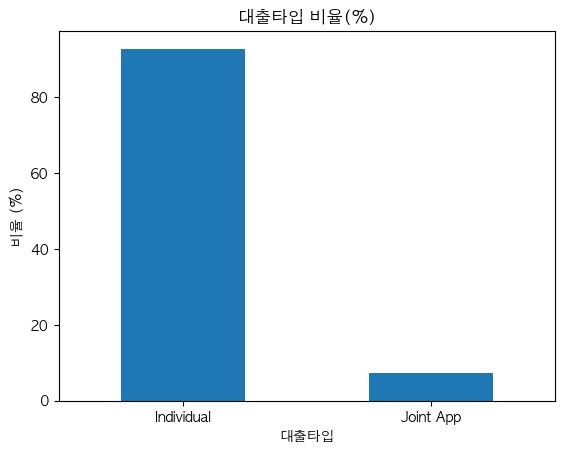

In [4]:
import matplotlib.pyplot as plt

# 한글 폰트 설정 (Mac용)
plt.rc("font", family="AppleGothic")

# 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

# application_type 별 건수
counts = df["application_type"].value_counts()

# application_type 별 비율(%) 계산
percentages = df["application_type"].value_counts(normalize=True) * 100

# 비율 출력
print("application_type 비율(%)")
print(percentages)
print()

# 바 차트 시각화
percentages.plot(kind="bar")
plt.title("대출타입 비율(%)")
plt.xlabel("대출타입")
plt.ylabel("비율 (%)")
plt.xticks(rotation=0)  # x축 라벨 가독성 조정
plt.show()

### 2. 신용등급별 fico score 분석

#### 2-1. grade 칼럼 밸류값의 종류 파악

In [11]:
print(df['grade'].unique())

# 각 등급별로 파악하기 위하여 nan값을 제외하기로 결정.

['A' 'C' 'E' 'B' 'D' 'G' 'F' nan]


In [12]:
# NaN 포함하여 개수 세기
grade_counts = df['grade'].value_counts(dropna=False)  # dropna=False -> NaN도 포함

# A~G 정렬 후 출력 (NaN은 마지막에 위치)
sorted_index = sorted(grade_counts.index, key=lambda x: (str(x) != 'nan', x)) 

# 정렬된 결과 출력
print(grade_counts.loc[sorted_index])

grade
NaN         1
A      393726
B      515082
C      481313
D      249328
E       83213
F       25303
G        7329
Name: count, dtype: int64


#### 2-2. grade 칼럼 전처리 후 fico score 기초통계량 도출

In [13]:
# ----------------------------------------
# 1. grade 컬럼이 NaN인 행 제거
# ----------------------------------------
df_clean = df.dropna(subset=['grade']).copy()

# ----------------------------------------
# 2. grade별 fico_range_low, fico_range_high의 기초통계량
# ----------------------------------------
stats = df_clean.groupby('grade')[['last_fico_range_low', 'last_fico_range_high']].describe()
print(stats)

# ----------------------------------------
# 3. 시각화 (박스플롯 & 바이올린플롯)
# ----------------------------------------

# (1) grade 별로 데이터를 리스트 형태로 추출
grades = sorted(df_clean['grade'].unique())  # 'a'~'g' 순서 및 결측 제거
fico_low_data = [df_clean[df_clean['grade'] == g]['last_fico_range_low'].dropna().values 
                 for g in grades]
fico_high_data = [df_clean[df_clean['grade'] == g]['last_fico_range_high'].dropna().values 
                  for g in grades]

      last_fico_range_low                                                    \
                    count        mean         std  min    25%    50%    75%   
grade                                                                         
A                393726.0  726.996884   73.419329  0.0  700.0  735.0  770.0   
B                515082.0  689.160998   98.761162  0.0  665.0  705.0  740.0   
C                481313.0  660.416984  118.421492  0.0  635.0  685.0  720.0   
D                249328.0  641.511703  129.662853  0.0  610.0  670.0  705.0   
E                 83213.0  616.613209  150.184789  0.0  575.0  650.0  695.0   
F                 25303.0  601.708493  158.467278  0.0  560.0  635.0  690.0   
G                  7329.0  589.931096  164.941224  0.0  555.0  625.0  680.0   

             last_fico_range_high                                              \
         max                count        mean        std    min    25%    50%   
grade                                          

#### 2-3. 각 등급별 fico score 시각화

##### 2-3-1. 박스플롯

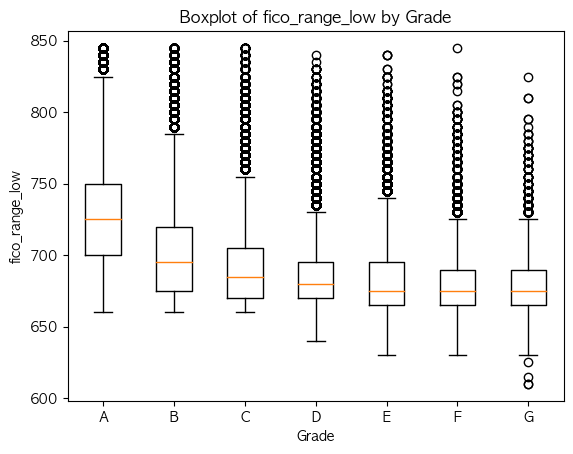

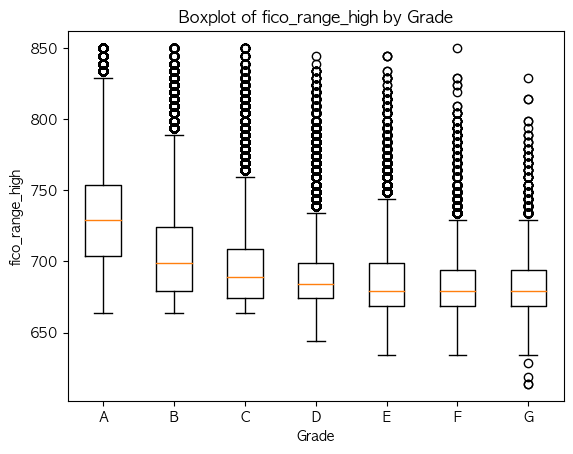

In [9]:
# --- (3-1) 박스플롯(boxplot) --- #
plt.boxplot(fico_low_data, labels=grades)
plt.title("Boxplot of fico_range_low by Grade")
plt.xlabel("Grade")
plt.ylabel("fico_range_low")
plt.show()

plt.boxplot(fico_high_data, labels=grades)
plt.title("Boxplot of fico_range_high by Grade")
plt.xlabel("Grade")
plt.ylabel("fico_range_high")
plt.show()

##### 2-3-2. 바이올린플롯

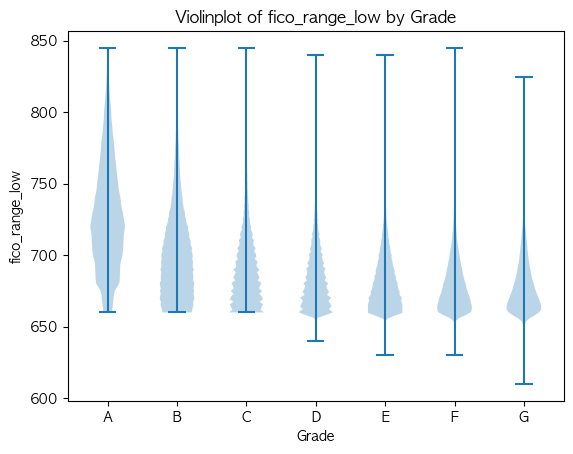

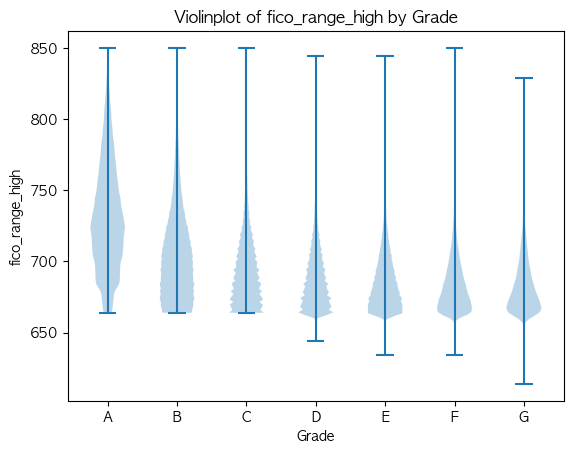

In [10]:
# --- (3-2) 바이올린플롯(violinplot) --- #
plt.violinplot(fico_low_data)
plt.title("Violinplot of fico_range_low by Grade")
plt.xlabel("Grade")
plt.ylabel("fico_range_low")
# x축 눈금(labels)을 grade 순서에 맞춰 세팅
plt.xticks(range(1, len(grades) + 1), grades)
plt.show()

plt.violinplot(fico_high_data)
plt.title("Violinplot of fico_range_high by Grade")
plt.xlabel("Grade")
plt.ylabel("fico_range_high")
plt.xticks(range(1, len(grades) + 1), grades)
plt.show()

#### 2-4. ANOVA (FICO Range)

In [15]:
import scipy.stats as stats

# 예: grade 컬럼 NaN 제거, 그리고 grade가 A~G 외의 값이 있다면 제거
df_clean = df.dropna(subset=['grade']).copy()
valid_grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']  # 등급 리스트
df_clean = df_clean[df_clean['grade'].isin(valid_grades)]

In [16]:
import scipy.stats as stats

# (1) 등급별로 fico_range_low를 그룹화
groups_low = [
    df_clean.loc[df_clean['grade'] == g, 'last_fico_range_low'].dropna().values 
    for g in valid_grades
]

# (2) 일원분산분석 시행
f_stat_low, p_val_low = stats.f_oneway(*groups_low)

print("ANOVA 결과 (last_fico_range_low ~ grade)")
print("F-statistic:", f_stat_low)
print("p-value:", p_val_low)

groups_high = [
    df_clean.loc[df_clean['grade'] == g, 'last_fico_range_high'].dropna().values 
    for g in valid_grades
]

f_stat_high, p_val_high = stats.f_oneway(*groups_high)

print("\nANOVA 결과 (last_fico_range_high ~ grade)")
print("F-statistic:", f_stat_high)
print("p-value:", p_val_high)

ANOVA 결과 (last_fico_range_low ~ grade)
F-statistic: 28240.07294741547
p-value: 0.0

ANOVA 결과 (last_fico_range_high ~ grade)
F-statistic: 49008.77484127617
p-value: 0.0


##### 2-4-1. ANOVA 결과 해석

ANOVA(일원분산분석) 실행 결과, fico_range_low와 high 모두 p-value가 0.0을 기록함으로써 등급별 fico_range 평균값이 동일하지 않다는 가정이 강하게 지지되고 있다.

##### 2-4-2. 사후검정
ANOVA 결과에 따라 등급별 fico score에 차이가 있다는 점을 도출하였다. 이에 구체적으로 어떤 등급들 사이에 명확한 차이가 있는지를 확인하기 위해 사후 검정을 진행한다.

In [18]:
# fico range low에 대한 등급별 평균 차이 검정
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# (1) fico_range_low를 대상으로, group 레이블은 grade
data_low = df_clean['last_fico_range_low'].dropna()
groups_low_label = df_clean.loc[data_low.index, 'grade']  # 동일 인덱스 기준 등급

# (2) Tukey’s HSD
tukey_low = pairwise_tukeyhsd(endog=data_low,      # 검정할 연속형 변수
                              groups=groups_low_label,  # 그룹(범주) 변수
                              alpha=0.05)
print(tukey_low)

# 결과 해석:
# reject=True => 두 그룹 간 평균 차이가 유의미

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj   lower     upper   reject
--------------------------------------------------------
     A      B  -37.8359   0.0  -38.5153  -37.1565   True
     A      C  -66.5799   0.0  -67.2696  -65.8902   True
     A      D  -85.4852   0.0  -86.3066  -84.6638   True
     A      E -110.3837   0.0 -111.6082 -109.1592   True
     A      F -125.2884   0.0 -127.3698 -123.2069   True
     A      G -137.0658   0.0 -140.8494 -133.2822   True
     B      C   -28.744   0.0  -29.3874  -28.1006   True
     B      D  -47.6493   0.0  -48.4323  -46.8663   True
     B      E  -72.5478   0.0  -73.7469  -71.3487   True
     B      F  -87.4525   0.0  -89.5191  -85.3859   True
     B      G  -99.2299   0.0 -103.0054  -95.4544   True
     C      D  -18.9053   0.0  -19.6972  -18.1134   True
     C      E  -43.8038   0.0  -45.0087  -42.5989   True
     C      F  -58.7085   0.0  -60.7785  -56.6385   True
     C      G  -70.4859   0.0  

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj   lower     upper   reject
--------------------------------------------------------
     A      B  -37.8359   0.0  -38.5153  -37.1565   True
     A      C  -66.5799   0.0  -67.2696  -65.8902   True
     A      D  -85.4852   0.0  -86.3066  -84.6638   True
     A      E -110.3837   0.0 -111.6082 -109.1592   True
     A      F -125.2884   0.0 -127.3698 -123.2069   True
     A      G -137.0658   0.0 -140.8494 -133.2822   True
     B      C   -28.744   0.0  -29.3874  -28.1006   True
     B      D  -47.6493   0.0  -48.4323  -46.8663   True
     B      E  -72.5478   0.0  -73.7469  -71.3487   True
     B      F  -87.4525   0.0  -89.5191  -85.3859   True
     B      G  -99.2299   0.0 -103.0054  -95.4544   True
     C      D  -18.9053   0.0  -19.6972  -18.1134   True
     C      E  -43.8038   0.0  -45.0087  -42.5989   True
     C      F  -58.7085   0.0  -60.7785  -56.6385   True
     C      G  -70.4859   0.0  

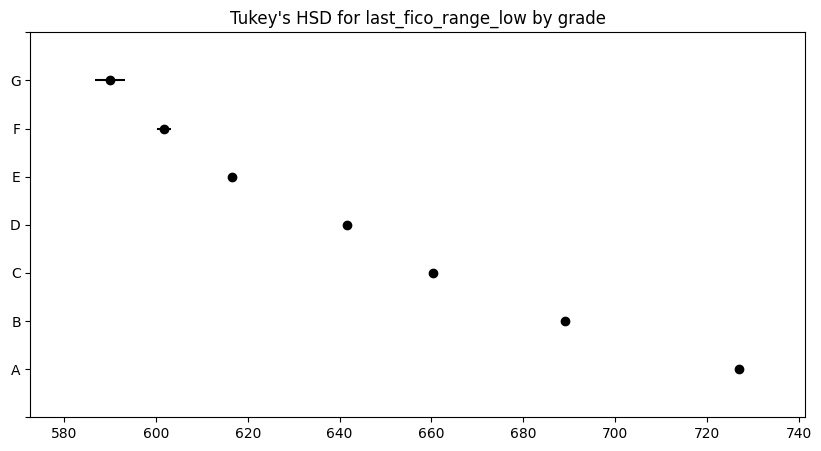

In [20]:
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import MultiComparison
# 1) MultiComparison 객체 생성
mc = MultiComparison(data_low, groups_low_label)

# 2) Tukey's HSD 수행
tukey_low = mc.tukeyhsd(alpha=0.05)
print(tukey_low)

# 3) 시각화 (plot_simultaneous)
fig = tukey_low.plot_simultaneous(figsize=(10,5)) 
plt.title("Tukey's HSD for last_fico_range_low by grade")
plt.show()

In [21]:
# fico range high에 대한 등급별 평균 차이 검정

# (1) fico_range_high를 대상으로, group 레이블은 grade
data_high = df_clean['last_fico_range_high'].dropna()
groups_high_label = df_clean.loc[data_low.index, 'grade']  # 동일 인덱스 기준 등급

# (2) Tukey’s HSD
tukey_high = pairwise_tukeyhsd(endog=data_low,      # 검정할 연속형 변수
                              groups=groups_low_label,  # 그룹(범주) 변수
                              alpha=0.05)
print(tukey_low)

# 결과 해석:
# reject=True => 두 그룹 간 평균 차이가 유의미

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj   lower     upper   reject
--------------------------------------------------------
     A      B  -37.8359   0.0  -38.5153  -37.1565   True
     A      C  -66.5799   0.0  -67.2696  -65.8902   True
     A      D  -85.4852   0.0  -86.3066  -84.6638   True
     A      E -110.3837   0.0 -111.6082 -109.1592   True
     A      F -125.2884   0.0 -127.3698 -123.2069   True
     A      G -137.0658   0.0 -140.8494 -133.2822   True
     B      C   -28.744   0.0  -29.3874  -28.1006   True
     B      D  -47.6493   0.0  -48.4323  -46.8663   True
     B      E  -72.5478   0.0  -73.7469  -71.3487   True
     B      F  -87.4525   0.0  -89.5191  -85.3859   True
     B      G  -99.2299   0.0 -103.0054  -95.4544   True
     C      D  -18.9053   0.0  -19.6972  -18.1134   True
     C      E  -43.8038   0.0  -45.0087  -42.5989   True
     C      F  -58.7085   0.0  -60.7785  -56.6385   True
     C      G  -70.4859   0.0  

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj   lower     upper   reject
--------------------------------------------------------
     A      B  -34.0955   0.0  -34.5274  -33.6636   True
     A      C  -57.9938   0.0  -58.4322  -57.5553   True
     A      D  -73.0857   0.0  -73.6079  -72.5635   True
     A      E  -90.5585   0.0   -91.337  -89.7801   True
     A      F -101.2275   0.0 -102.5508  -99.9043   True
     A      G -109.0443   0.0 -111.4496 -106.6389   True
     B      C  -23.8983   0.0  -24.3073  -23.4892   True
     B      D  -38.9902   0.0   -39.488  -38.4924   True
     B      E   -56.463   0.0  -57.2253  -55.7007   True
     B      F   -67.132   0.0  -68.4458  -65.8183   True
     B      G  -74.9488   0.0   -77.349  -72.5486   True
     C      D  -15.0919   0.0  -15.5954  -14.5885   True
     C      E  -32.5648   0.0  -33.3308  -31.7988   True
     C      F  -43.2338   0.0  -44.5497  -41.9178   True
     C      G  -51.0505   0.0  

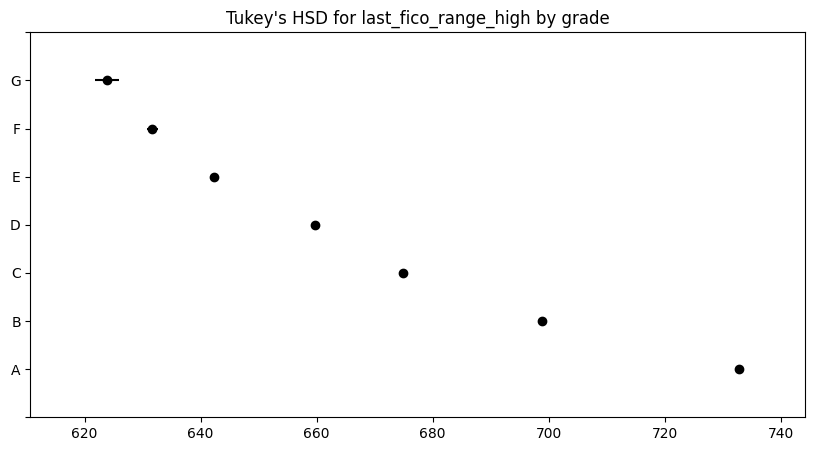

In [22]:
from statsmodels.stats.multicomp import MultiComparison
# 1) MultiComparison 객체 생성
mc = MultiComparison(data_high, groups_high_label)

# 2) Tukey's HSD 수행
tukey_high = mc.tukeyhsd(alpha=0.05)
print(tukey_high)

# 3) 시각화 (plot_simultaneous)
fig = tukey_high.plot_simultaneous(figsize=(10,5)) 
plt.title("Tukey's HSD for last_fico_range_high by grade")
plt.show()

##### 2-4-3. 사후검정 결과 해석
사후검정 결과 모든 grade들 간의 귀무가설이 유의수준 0.05%에서 기각되어 모든 그룹 사이의 fico_score의 평균에 차이가 없지 않다는 점을 지지한다

### 3. 신용등급별 DTI 분석

#### 3-1. 기초통계량 도출

In [4]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


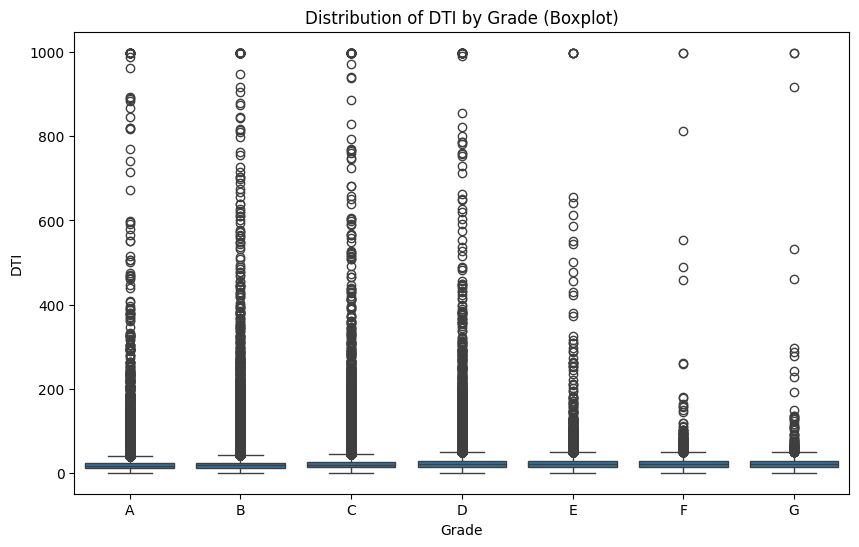

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# (1) grade와 dti 결측치 제거
df_clean = df.dropna(subset=['grade','dti']).copy()

# (2) grade가 A~G 이외의 값이 있으면 필터링 (필요 시)
valid_grades = ['A','B','C','D','E','F','G']
df_clean = df_clean[df_clean['grade'].isin(valid_grades)]

# (3) 박스플롯
plt.figure(figsize=(10,6))
sns.boxplot(x='grade', y='dti', data=df_clean, order=valid_grades)
plt.title('Distribution of DTI by Grade (Boxplot)')
plt.xlabel('Grade')
plt.ylabel('DTI')
plt.show()

# 각 등급별 아웃라이어가 너무 다양해 로그변환하여 분석 진행 결정.

#### 3-2. 로그변환 후 기초통계량 도출 및 시각화(박스플롯)

In [32]:
# (1) grade, dti NaN 제거
df_clean = df.dropna(subset=['grade', 'dti']).copy()

# (2) 등급 범위 제한 (A~G만)
valid_grades = ['A','B','C','D','E','F','G']
df_clean = df_clean[df_clean['grade'].isin(valid_grades)]

# (3) dti 로그 변환: log(dti + 1)
df_clean['dti_log'] = np.log1p(df_clean['dti'])  # np.log1p(x) == np.log(1 + x)

# (4) grade별로 dti_log의 기초 통계량 요약
stats_log = df_clean.groupby('grade')['dti_log'].describe()
print(stats_log)

          count      mean       std  min       25%       50%       75%  \
grade                                                                    
A      393346.0  2.739591  0.588319  0.0  2.437990  2.823757  3.139400   
B      514574.0  2.827522  0.572025  0.0  2.540814  2.913437  3.216072   
C      480787.0  2.905060  0.560873  0.0  2.626840  2.995232  3.286161   
D      248981.0  2.978609  0.561609  0.0  2.707383  3.071303  3.358638   
E       83147.0  2.984119  0.556885  0.0  2.724580  3.088311  3.365225   
F       25282.0  2.997618  0.541896  0.0  2.745988  3.099642  3.367296   
G        7316.0  3.000812  0.586168  0.0  2.751748  3.116400  3.379037   

            max  
grade            
A      6.907755  
B      6.907755  
C      6.907755  
D      6.907755  
E      6.907755  
F      6.907755  
G      6.907755  


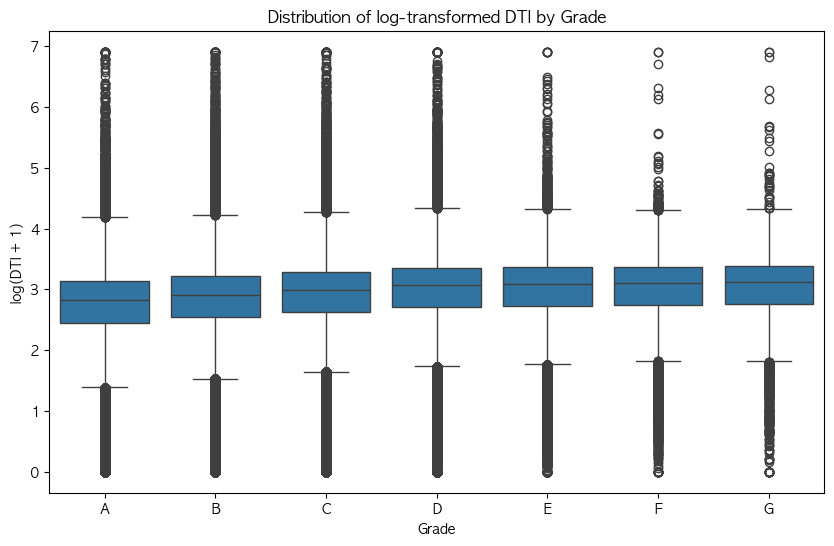

In [33]:
plt.figure(figsize=(10,6))
sns.boxplot(x='grade', y='dti_log', data=df_clean, order=valid_grades)
plt.title('Distribution of log-transformed DTI by Grade')
plt.xlabel('Grade')
plt.ylabel('log(DTI + 1)')
plt.show()

#### 3-3. ANOVA 분석 (DTI)

In [ ]:
import scipy.stats as stats

# 1) dti, grade가 결측치가 아닌 행만 선택
df_clean = df.dropna(subset=['dti', 'grade']).copy()

# 2) grade 범위 필터링 (A~G 등급만)
valid_grades = ['A','B','C','D','E','F','G']
df_clean = df_clean[df_clean['grade'].isin(valid_grades)]

# 3) dti의 로그 변환 (log1p => log(dti + 1))
df_clean['dti_log'] = np.log1p(df_clean['dti'])

# 4) 등급별로 dti_log 데이터 준비
grouped_data = []
for g in valid_grades:
    group = df_clean.loc[df_clean['grade'] == g, 'dti_log'].dropna().values
    grouped_data.append(group)

# 5) 일원분산분석 수행 (scipy.stats의 f_oneway)
f_stat, p_val = stats.f_oneway(*grouped_data)

print("ANOVA 결과 (log-transformed dti ~ grade)")
print("F-statistic:", f_stat)
print("p-value:", p_val)

# ANOVA 실행 결과 p-value가 0.05보다 작으므로, 적어도 하나의 등급 간 평균값이 유의미하게 차이난다는 것을 의미 따라서 사후 검정 수행

ANOVA 결과 (log-transformed dti ~ grade)
F-statistic: 6473.724989736973
p-value: 0.0


##### 3-3-1. 사후 검정

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     A      B   0.0879    0.0  0.0844 0.0915   True
     A      C   0.1655    0.0  0.1619 0.1691   True
     A      D    0.239    0.0  0.2347 0.2433   True
     A      E   0.2445    0.0  0.2381 0.2509   True
     A      F    0.258    0.0  0.2471 0.2689   True
     A      G   0.2612    0.0  0.2414 0.2811   True
     B      C   0.0775    0.0  0.0742 0.0809   True
     B      D   0.1511    0.0   0.147 0.1552   True
     B      E   0.1566    0.0  0.1503 0.1629   True
     B      F   0.1701    0.0  0.1593 0.1809   True
     B      G   0.1733    0.0  0.1535 0.1931   True
     C      D   0.0735    0.0  0.0694 0.0777   True
     C      E   0.0791    0.0  0.0727 0.0854   True
     C      F   0.0926    0.0  0.0817 0.1034   True
     C      G   0.0958    0.0  0.0759 0.1156   True
     D      E   0.0055 0.1931 -0.0012 0.0122  False
     D      

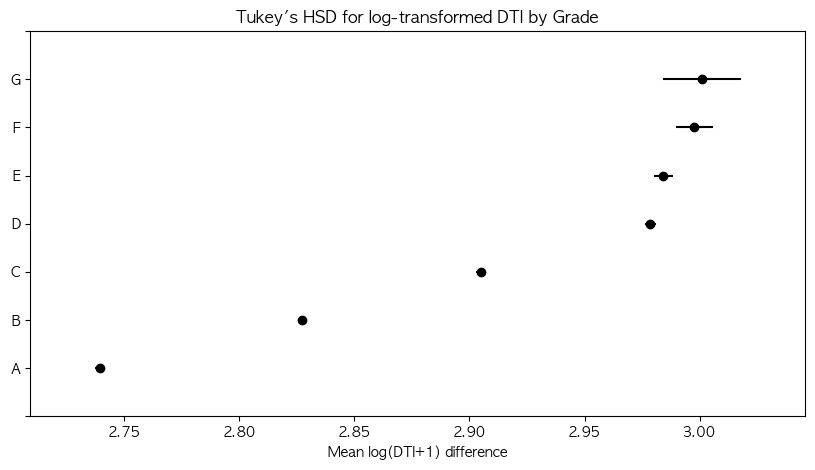

In [36]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

# -------------------------------
# 1) 데이터 준비 (로그 변환 포함)
# -------------------------------
df_clean = df.dropna(subset=['dti','grade']).copy()

valid_grades = ['A','B','C','D','E','F','G']
df_clean = df_clean[df_clean['grade'].isin(valid_grades)]

# 로그 변환
df_clean['dti_log'] = np.log1p(df_clean['dti'])

# -------------------------------
# 3) Tukey’s HSD 사후검정
# -------------------------------
# (1) 데이터, 그룹 레이블 정의
data_log = df_clean['dti_log'].dropna()
groups_label = df_clean.loc[data_log.index, 'grade']  # 인덱스 맞춰서 grade 추출

# (2) Tukey’s HSD
tukey_result = pairwise_tukeyhsd(endog=data_log, 
                                 groups=groups_label,
                                 alpha=0.05)
print(tukey_result)

# -------------------------------
# 4) 시각화
# -------------------------------
# 4-1) 텍스트 표 기반으로도 출력 가능
# tukey_result.summary()

# 4-2) plot_simultaneous() 이용
fig = tukey_result.plot_simultaneous(figsize=(10,5))
plt.title("Tukey's HSD for log-transformed DTI by Grade")
plt.xlabel("Mean log(DTI+1) difference")
plt.show()

# 사후 검정 결과 D와 E, E와 G, F와 G의 하위 등급 사이에서는 DTI가 차이가 없다. 그러나 상위 등급 사이에는 명확한 차이가 존재하는 것으로 해석이 가능하다.

### 4. Sharpe Ratio의 무위험 수익률을 정의내리기 위해, 각 대출자들의 대출 시점 (월 단위) 에 분포 되어 있는 3년물, 5년물 국채의 수익률 분포 확인

#### 4-1. 사전준비 (데이터 분할 및 데이터 별 대출시행날짜의 고유값 확인)

In [40]:
# 각 대출만기 (3년 및 5년)에 따라 서로 다른 국채의 금리를 적용해야 하므로 데이터를 term에 따라 분리하여 분석 진행.

# term 컬럼 값에 혹시 공백이 있다면 제거(필요할 경우)
df['term'] = df['term'].str.strip()  # 예: ' 36 months' -> '36 months'

# term이 '36 months'인 행만 추출하고 term 컬럼은 드롭
df_36 = df[df['term'] == '36 months'].drop('term', axis=1)

# term이 '60 months'인 행만 추출하고 term 컬럼은 드롭
df_60 = df[df['term'] == '60 months'].drop('term', axis=1)

In [42]:
# 36개월 대출자들의 대출 발행 연도의 고유값 확인

# 1. issue_d가 NaN인 행 제거
df36_clean = df_36.dropna(subset=['issue_d']).copy()

# 2. issue_d 컬럼의 고유값 추출
issue_d_unique_36 = df36_clean['issue_d'].unique()

# 3. 개수와 함께 확인
print(f"issue_d 고유값 개수: {len(issue_d_unique_36)}")

# 4. 판다스의 출력 옵션 설정 (max_rows=None로)
pd.set_option('display.max_rows', None)

# 5. 고유값 전체 출력 (Series로 변환하면 행 형태로 보기가 편함)
print(pd.Series(issue_d_unique_36))

issue_d 고유값 개수: 160
0      Dec-2017
1      Apr-2019
2      Oct-2017
3      May-2017
4      Sep-2015
5      May-2019
6      Dec-2019
7      Oct-2016
8      Oct-2018
9      Sep-2017
10     Jan-2017
11     Sep-2014
12     Apr-2014
13     Feb-2020
14     Jul-2017
15     Jun-2016
16     Nov-2017
17     Nov-2018
18     Mar-2015
19     May-2018
20     Oct-2019
21     Sep-2020
22     Jan-2016
23     Feb-2019
24     Sep-2019
25     Dec-2015
26     Apr-2015
27     Jun-2020
28     Jun-2017
29     Mar-2013
30     Mar-2016
31     May-2016
32     Mar-2018
33     Aug-2019
34     Jul-2020
35     Feb-2016
36     Jun-2015
37     Sep-2016
38     Mar-2017
39     Jan-2013
40     Oct-2015
41     Aug-2016
42     Dec-2018
43     Apr-2018
44     Aug-2018
45     Jan-2018
46     Dec-2016
47     Jun-2018
48     Jan-2019
49     Aug-2020
50     Feb-2018
51     May-2015
52     Jun-2014
53     Jul-2012
54     Feb-2017
55     Jul-2016
56     Nov-2019
57     Jul-2015
58     Aug-2017
59     Dec-2013
60     Feb-2014
61  

In [43]:
# 60개월 대출자들의 대출 발행 연도의 고유값 확인

# 1. issue_d가 NaN인 행 제거
df60_clean = df_60.dropna(subset=['issue_d']).copy()

# 2. issue_d 컬럼의 고유값 추출
issue_d_unique_60 = df60_clean['issue_d'].unique()

# 3. 개수와 함께 확인
print(f"issue_d 고유값 개수: {len(issue_d_unique_60)}")

# 4. 판다스의 출력 옵션 설정 (max_rows=None로)
pd.set_option('display.max_rows', None)

# 5. 고유값 전체 출력 (Series로 변환하면 행 형태로 보기가 편함)
print(pd.Series(issue_d_unique_60))

issue_d 고유값 개수: 125
0      Sep-2018
1      Jul-2016
2      May-2019
3      Mar-2020
4      Dec-2018
5      Mar-2019
6      May-2015
7      Oct-2014
8      Sep-2015
9      Aug-2019
10     Jan-2017
11     Sep-2013
12     Apr-2018
13     Oct-2015
14     Feb-2016
15     Jul-2020
16     Jan-2020
17     Aug-2015
18     Oct-2018
19     Oct-2017
20     Jan-2019
21     Nov-2014
22     Apr-2016
23     Jun-2017
24     Nov-2015
25     Mar-2018
26     Jul-2017
27     Jan-2013
28     Dec-2017
29     Jan-2016
30     Mar-2015
31     Sep-2012
32     Jul-2015
33     Jul-2018
34     Jan-2015
35     Jun-2019
36     Dec-2015
37     Sep-2016
38     May-2017
39     Feb-2019
40     Mar-2014
41     May-2018
42     Jun-2020
43     Apr-2014
44     Apr-2012
45     Aug-2016
46     Dec-2016
47     Jul-2012
48     Apr-2015
49     Sep-2017
50     Jun-2018
51     Jun-2014
52     Nov-2017
53     Nov-2016
54     Sep-2011
55     Nov-2018
56     Jul-2013
57     Jan-2018
58     Dec-2013
59     Feb-2017
60     Feb-2014
61  

#### 4-2. 각 데이터 별 미국채 금리의 한달 평균 및 최대, 최소값 도출 후 최댓값과 최솟값의 차이 그래프로 시각화

##### 4-2-1. 36개월 대출자

In [45]:
pip install pandas_datareader

  Using cached pandas_datareader-0.10.0-py3-none-any.whl.metadata (2.9 kB)
Using cached pandas_datareader-0.10.0-py3-none-any.whl (109 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# yfinance에 3년물 국채 티커가 지원이 안되므로 Pandas DataReader의 FRED(Federal Reserve Economic Data)를 이용하여 
# 3년물 국채 금리 데이터 임포트

import datetime
import pandas as pd
import numpy as np
from pandas_datareader import data as web
from dateutil.relativedelta import relativedelta

# 가정: df_36에는 'issue_d' 컬럼이 있음
# 1) issue_d가 NaN이 아닌 행만 필터
df36_clean = df_36.dropna(subset=['issue_d']).copy()

# 2) issue_d 컬럼의 고유값 추출
issue_d_unique_36 = df36_clean['issue_d'].unique()

results = []

for val in issue_d_unique_36:
    # val 예: "Dec-2017"
    try:
        # (a) 문자열 -> datetime (해당 월의 1일)
        dt = datetime.datetime.strptime(val, '%b-%Y')  
        # 예: "Dec-2017" -> datetime(2017, 12, 1)

        # (b) 시작일: 해당 월 1일, 종료일: 다음 달 1일 - 1일(=해당 월 말일)
        start_date_dt = dt.replace(day=1)  # 2017-12-01
        end_date_dt = (start_date_dt + relativedelta(months=1)) - datetime.timedelta(days=1)
        # => 2017-12-31
        
        # (c) FRED에서 DGS3(3년물) 일별 데이터 받아오기
        # pandas_datareader: DataReader('DGS3', 'fred', 시작일, 종료일)
        df_3yr = web.DataReader('DGS3', 'fred', start_date_dt, end_date_dt)
        # df_3yr.index: DatetimeIndex
        # df_3yr.columns: ['DGS3']

        if df_3yr.empty:
            # 해당 월에 데이터가 전혀 없으면 NaN 처리
            avg_val, min_val, max_val = np.nan, np.nan, np.nan
        else:
            close_vals = df_3yr['DGS3'].dropna()  # 일별 3년물 금리
            if close_vals.empty:
                avg_val, min_val, max_val = np.nan, np.nan, np.nan
            else:
                avg_val = close_vals.mean()
                min_val = close_vals.min()
                max_val = close_vals.max()

        results.append({
            "issue_d": val,
            "start_date": start_date_dt.strftime('%Y-%m-%d'),
            "end_date": end_date_dt.strftime('%Y-%m-%d'),
            "3yr_mean": avg_val,
            "3yr_min": min_val,
            "3yr_max": max_val
        })

    except ValueError:
        # '%b-%Y' 형태로 파싱 불가능한 case 처리
        results.append({
            "issue_d": val,
            "start_date": None,
            "end_date": None,
            "3yr_mean": np.nan,
            "3yr_min": np.nan,
            "3yr_max": np.nan
        })

# 4) 결과를 DataFrame으로 정리
df_3yr_stats = pd.DataFrame(results)

# 5) 3년물 통계 확인
print("===== 3년물 (FRED: DGS3) 월별 통계량 =====")
print(df_3yr_stats)

===== 3년물 (FRED: DGS3) 월별 통계량 =====
      issue_d  start_date    end_date  3yr_mean  3yr_min  3yr_max
0    Dec-2017  2017-12-01  2017-12-31  1.955000     1.90     2.02
1    Apr-2019  2019-04-01  2019-04-30  2.308571     2.24     2.38
2    Oct-2017  2017-10-01  2017-10-31  1.682857     1.62     1.76
3    May-2017  2017-05-01  2017-05-31  1.483636     1.42     1.57
4    Sep-2015  2015-09-01  2015-09-30  1.013333     0.92     1.13
5    May-2019  2019-05-01  2019-05-31  2.162727     1.90     2.32
6    Dec-2019  2019-12-01  2019-12-31  1.633810     1.54     1.69
7    Oct-2016  2016-10-01  2016-10-31  0.989000     0.91     1.04
8    Oct-2018  2018-10-01  2018-10-31  2.935909     2.85     2.99
9    Sep-2017  2017-09-01  2017-09-30  1.513000     1.38     1.62
10   Jan-2017  2017-01-01  2017-01-31  1.479000     1.42     1.53
11   Sep-2014  2014-09-01  2014-09-30  1.050952     0.99     1.10
12   Apr-2014  2014-04-01  2014-04-30  0.884762     0.80     0.95
13   Feb-2020  2020-02-01  2020-02-29  1

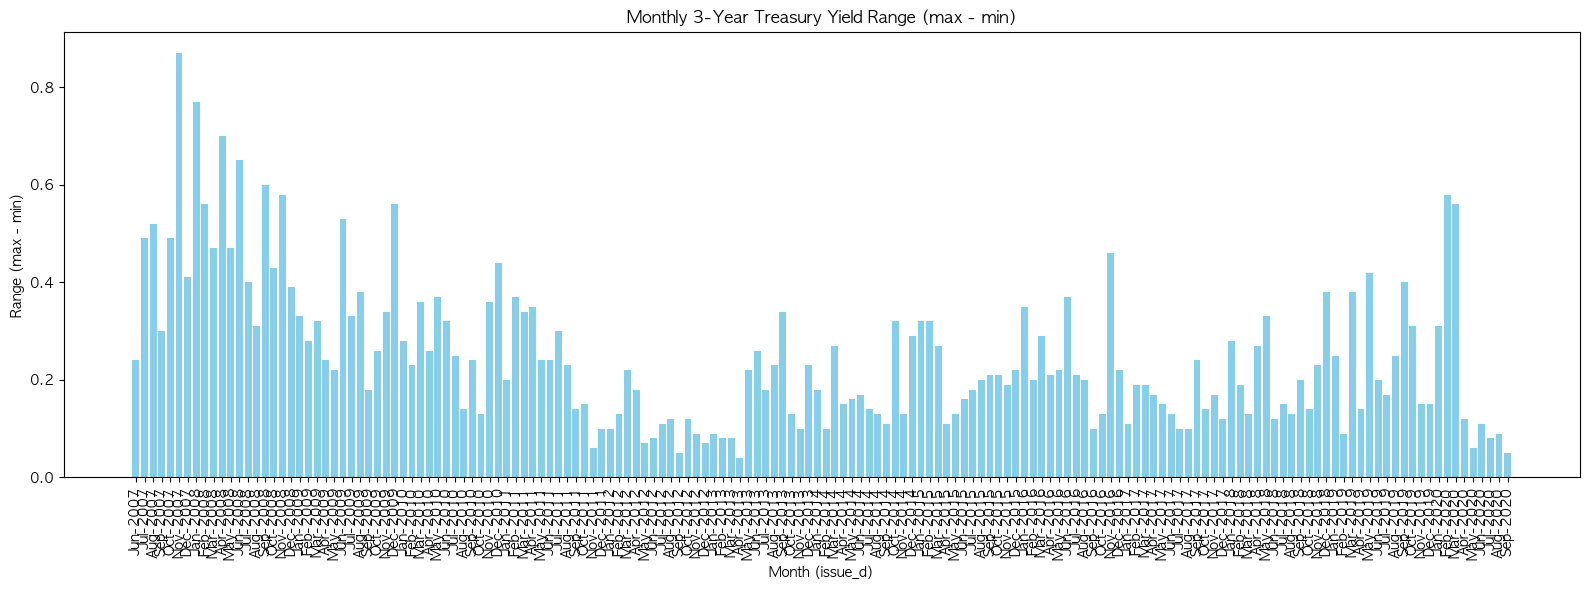

In [50]:
# 1. df_3yr_stats에 저장된 각 월별 3년물 금리의 최대값과 최소값의 차이를 계산
df_3yr_stats['range'] = df_3yr_stats['3yr_max'] - df_3yr_stats['3yr_min']

# 2. issue_d (예: "Dec-2017")를 datetime으로 변환하여 날짜 순으로 정렬
df_3yr_stats['month_dt'] = pd.to_datetime(df_3yr_stats['issue_d'], format='%b-%Y')
df_3yr_stats = df_3yr_stats.sort_values('month_dt')

# 3. 막대그래프로 각 월별 range (max - min) 표시
plt.figure(figsize=(16,6))
plt.bar(df_3yr_stats['month_dt'].dt.strftime('%b-%Y'), df_3yr_stats['range'], color='skyblue')
plt.xticks(rotation=90)
plt.xlabel("Month (issue_d)")
plt.ylabel("Range (max - min)")
plt.title("Monthly 3-Year Treasury Yield Range (max - min)")
plt.tight_layout()
plt.show()

##### 4-2-2. 60개월 대출자

In [47]:
# df_60에는 'issue_d' 컬럼이 있다고 가정
# 1) issue_d가 NaN이 아닌 행만 필터
df60_clean = df_60.dropna(subset=['issue_d']).copy()

# 2) issue_d 컬럼의 고유값 추출
issue_d_unique_60 = df60_clean['issue_d'].unique()

results_5yr = []

for val in issue_d_unique_60:
    # val 예: "Dec-2017"
    try:
        # (a) 문자열 -> datetime (해당 월 1일)
        dt = datetime.datetime.strptime(val, '%b-%Y')  
        # 예: "Dec-2017" -> datetime(2017, 12, 1)

        # (b) 시작일: 해당 월 첫째 날, 종료일: 다음 달 1일 - 1일(=월말)
        start_date_dt = dt.replace(day=1)  
        end_date_dt = (start_date_dt + relativedelta(months=1)) - datetime.timedelta(days=1)

        # (c) pandas_datareader로 5년물 (DGS5) 일별 데이터 받아오기
        df_5yr = web.DataReader('DGS5', 'fred', start_date_dt, end_date_dt)

        if df_5yr.empty:
            # 해당 월에 데이터가 전혀 없으면 NaN
            avg_val, min_val, max_val = np.nan, np.nan, np.nan
        else:
            close_vals = df_5yr['DGS5'].dropna()
            if close_vals.empty:
                avg_val, min_val, max_val = np.nan, np.nan, np.nan
            else:
                avg_val = close_vals.mean()
                min_val = close_vals.min()
                max_val = close_vals.max()

        results_5yr.append({
            "issue_d": val,
            "start_date": start_date_dt.strftime('%Y-%m-%d'),
            "end_date": end_date_dt.strftime('%Y-%m-%d'),
            "5yr_mean": avg_val,
            "5yr_min": min_val,
            "5yr_max": max_val
        })

    except ValueError:
        # '%b-%Y' 파싱 불가능한 경우 처리
        results_5yr.append({
            "issue_d": val,
            "start_date": None,
            "end_date": None,
            "5yr_mean": np.nan,
            "5yr_min": np.nan,
            "5yr_max": np.nan
        })

# 3) 결과를 DataFrame으로 정리
df_5yr_stats = pd.DataFrame(results_5yr)

# 4) 5년물 통계 확인
print("===== 5년물 (FRED: DGS5) 월별 통계량 =====")
print(df_5yr_stats)

===== 5년물 (FRED: DGS5) 월별 통계량 =====
      issue_d  start_date    end_date  5yr_mean  5yr_min  5yr_max
0    Sep-2018  2018-09-01  2018-09-30  2.893684     2.76     2.99
1    Jul-2016  2016-07-01  2016-07-31  1.071500     0.94     1.15
2    May-2019  2019-05-01  2019-05-31  2.187727     1.93     2.34
3    Mar-2020  2020-03-01  2020-03-31  0.591818     0.37     0.88
4    Dec-2018  2018-12-01  2018-12-31  2.681579     2.51     2.83
5    Mar-2019  2019-03-01  2019-03-31  2.372857     2.18     2.56
6    May-2015  2015-05-01  2015-05-31  1.538500     1.46     1.60
7    Oct-2014  2014-10-01  2014-10-31  1.545909     1.37     1.73
8    Sep-2015  2015-09-01  2015-09-30  1.490000     1.37     1.62
9    Aug-2019  2019-08-01  2019-08-31  1.486818     1.37     1.68
10   Jan-2017  2017-01-01  2017-01-31  1.916500     1.84     1.99
11   Sep-2013  2013-09-01  2013-09-30  1.596000     1.39     1.85
12   Apr-2018  2018-04-01  2018-04-30  2.701905     2.55     2.84
13   Oct-2015  2015-10-01  2015-10-31  1

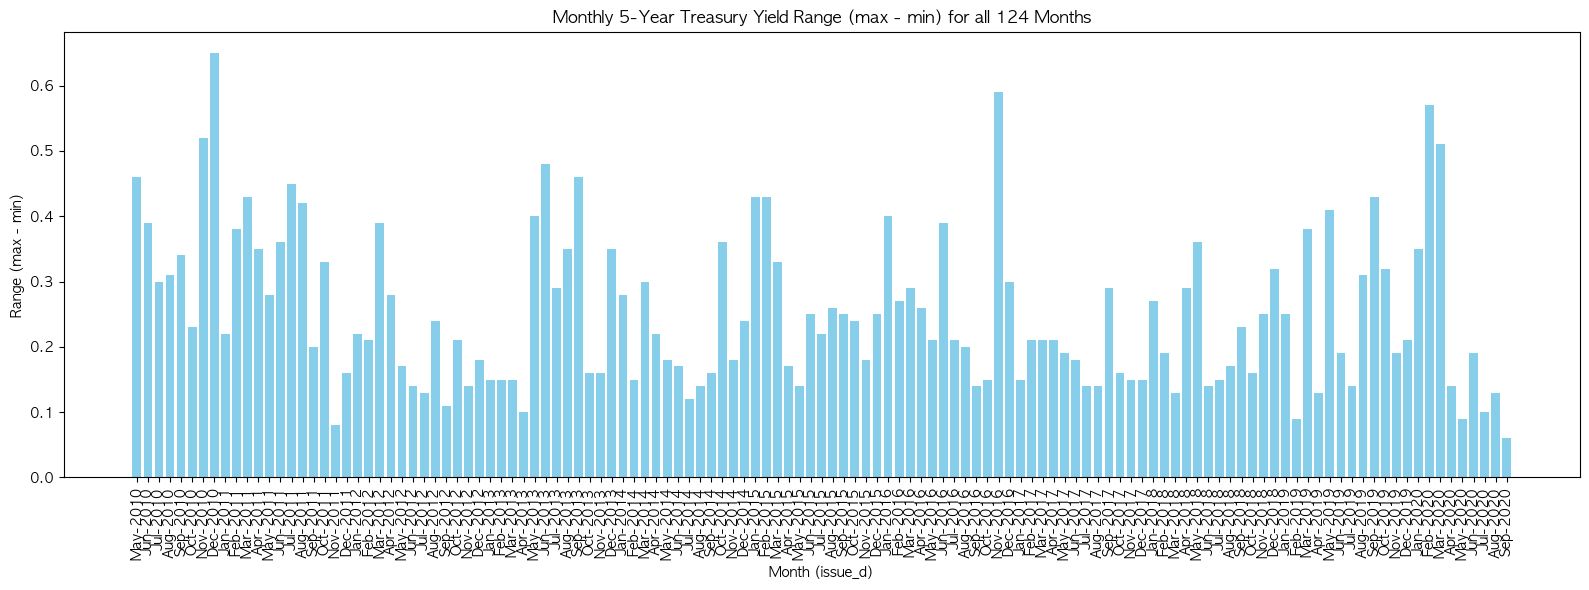

In [49]:
# issue_d 문자열("Dec-2017" 등)을 datetime으로 변환하는 새로운 컬럼 생성
df_5yr_stats['month_dt'] = pd.to_datetime(df_5yr_stats['issue_d'], format='%b-%Y')

# 날짜 순으로 정렬
df_5yr_stats = df_5yr_stats.sort_values('month_dt')

# 그래프 그리기: 각 월의 range (max - min) 값을 막대그래프로 표시
plt.figure(figsize=(16,6))
plt.bar(df_5yr_stats['month_dt'].dt.strftime('%b-%Y'), df_5yr_stats['range'], color='skyblue')
plt.xticks(rotation=90)
plt.xlabel("Month (issue_d)")
plt.ylabel("Range (max - min)")
plt.title("Monthly 5-Year Treasury Yield Range (max - min) for all 124 Months")
plt.tight_layout()
plt.show()

### 5. 신용등급별 loan_staus 분포 확인 (Fully Paid, Charge off, Default 항목의 경우만 확인)

#### 5-1. 기존 데이터셋에서의 loan_status 비율 확인

In [9]:
# 기존 데이터 loan_status의 비율 파악
# 1️⃣ 전체 loan_status별 개수 계산
status_counts = df['loan_status'].value_counts()

# 2️⃣ 전체 데이터에서 loan_status별 비율(%) 계산
status_ratio = (status_counts / len(df)) * 100

# 3️⃣ 결과 출력
print("Loan Status Distribution (Count & Percentage in Full Dataset)")
print(status_counts)
print("\nPercentage Distribution:")
print(status_ratio.round(2))  # 소수점 2자리까지 출력

Loan Status Distribution (Count & Percentage in Full Dataset)
loan_status
Fully Paid                                             898522
Current                                                618688
Charged Off                                            217366
Late (31-120 days)                                       9840
In Grace Period                                          6049
Late (16-30 days)                                        1620
Issued                                                   1258
Does not meet the credit policy. Status:Fully Paid       1223
Does not meet the credit policy. Status:Charged Off       460
Default                                                   268
Name: count, dtype: int64

Percentage Distribution:
loan_status
Fully Paid                                             51.19
Current                                                35.25
Charged Off                                            12.38
Late (31-120 days)                                      0.5

#### 5-2. 모델을 돌릴 때 사용하기로 한 정보 (FP, CO, De만 걸러내어 분포 확인)

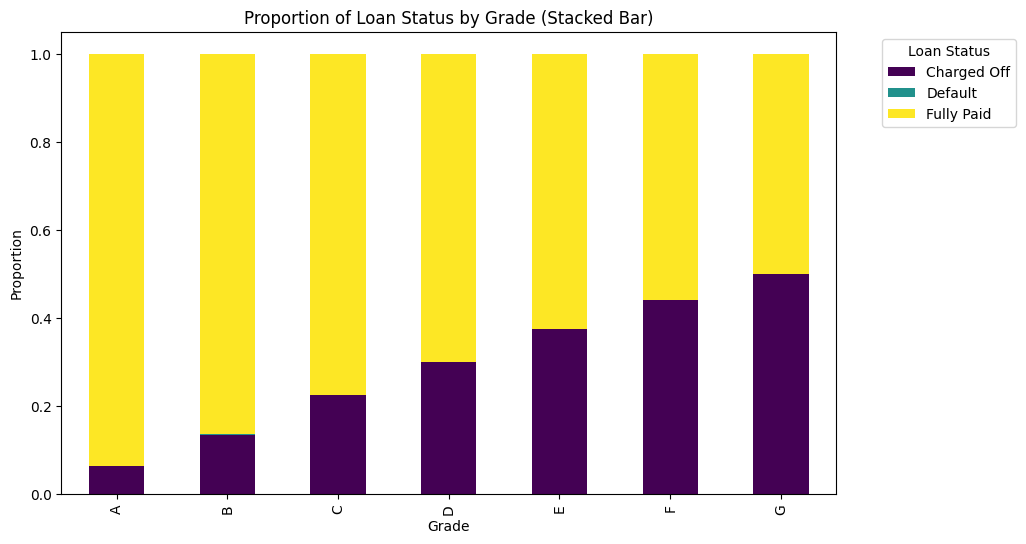

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# loan_status 필터링 (Fully Paid, Charged Off, Default만 유지)
valid_status = ["Fully Paid", "Charged Off", "Default"]
df_filtered = df[df['loan_status'].isin(valid_status)].copy()

# grade에서 NaN 값 제거
df_filtered = df_filtered.dropna(subset=['grade'])

# loan_status 비율 계산
df_grouped = df_filtered.groupby(['grade', 'loan_status']).size().unstack()
df_grouped = df_grouped.div(df_grouped.sum(axis=1), axis=0)  # 각 grade별 비율 계산

# Stacked Bar Chart 시각화
ax = df_grouped.plot(kind='bar', stacked=True, figsize=(10,6), colormap='viridis')

# 제목, 축 라벨 설정
plt.title("Proportion of Loan Status by Grade (Stacked Bar)")
plt.xlabel("Grade")
plt.ylabel("Proportion")

# 범례를 그래프 바깥으로 이동 (오른쪽)
plt.legend(title="Loan Status", bbox_to_anchor=(1.05, 1), loc='upper left')

# 그래프 출력
plt.show()

In [11]:
# 1️⃣ loan_status 필터링
valid_status = ["Fully Paid", "Charged Off", "Default"]
df_filtered = df[df['loan_status'].isin(valid_status)].copy()

# 2️⃣ 전체 데이터에서 loan_status별 개수 계산
status_counts = df_filtered['loan_status'].value_counts()

# 3️⃣ 비율(%) 계산
status_ratio = status_counts / status_counts.sum() * 100

# 4️⃣ 결과 출력
print("Loan Status Distribution (Count & Percentage)")
print(status_counts)
print("\nPercentage Distribution:")
print(status_ratio.round(2))  # 소수점 2자리까지 표시

Loan Status Distribution (Count & Percentage)
loan_status
Fully Paid     898522
Charged Off    217366
Default           268
Name: count, dtype: int64

Percentage Distribution:
loan_status
Fully Paid     80.50
Charged Off    19.47
Default         0.02
Name: count, dtype: float64


#### 5-3. 그룹별 완납 여부의 차이를 통계적으로 검정 (로지스틱 회귀)

In [14]:
import statsmodels.api as sm
import pandas as pd

# 1️⃣ Fully Paid 여부를 이진 변수(1=Fully Paid, 0=나머지)로 변환
df_filtered['fully_paid_binary'] = (df_filtered['loan_status'] == "Fully Paid").astype(int)

# 2️⃣ grade만 원-핫 인코딩 수행 (sub_grade는 포함하지 않음)
df_model = pd.get_dummies(df_filtered, columns=['grade'], drop_first=True)

# 3️⃣ 독립 변수(X): 'grade_'가 포함된 컬럼만 선택 (sub_grade 제외)
X = df_model.loc[:, df_model.columns.str.startswith('grade_')].astype(float)  
X = sm.add_constant(X)  # 절편 추가

# 4️⃣ 종속 변수(y): Fully Paid 여부 (0 또는 1)
y = df_filtered['fully_paid_binary']

# 5️⃣ 로지스틱 회귀 분석 수행
model = sm.Logit(y, X).fit()

# 6️⃣ 결과 출력
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.461515
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:      fully_paid_binary   No. Observations:              1116156
Model:                          Logit   Df Residuals:                  1116149
Method:                           MLE   Df Model:                            6
Date:                Sun, 02 Mar 2025   Pseudo R-squ.:                 0.06457
Time:                        15:46:04   Log-Likelihood:            -5.1512e+05
converged:                       True   LL-Null:                   -5.5068e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6742      0.009    299.511      0.000       2.657       2.692
grade_B       -0.8202      0.

##### 5-3-1. 로지스틱 회귀 결과 분석

A등급을 기준으로 모든 그룹의 계수가 음수로 나오고 p-value도 0.000으로 통계적으로 유의하다. 또한 신용등급이 낮아질수록 계수가 점점 감소하고 있으므로 A등급을 기준으로 할 때, 그보다 신용등급이 낮은 대출자들의 완납 확률이 급격히 적어진다고 이야기할 수 있다.

### 6. 여러가지 칼럼들 간 상관계수 분석을 통한 피쳐 셀렉션

#### 6-1. 전체 데이터셋 중 연속형 변수로 작성된 것에 한해 상관계수가 높은 칼럼들 탐색

In [29]:
import pandas as pd
import numpy as np

# 2. 연속형 변수(숫자형 컬럼) 선택
df_numeric = df.select_dtypes(include=[np.number])

# 3. 상관계수 행렬 계산
corr_matrix = df_numeric.corr()

# 4. 상관계수 절대값이 threshold 이상인 변수 쌍 찾기
threshold = 0.85
high_corr_pairs = []

cols = corr_matrix.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) >= threshold:
            high_corr_pairs.append((cols[i], cols[j], corr_val))

# 5. 결과 텍스트로 출력
if high_corr_pairs:
    print("Pairs of variables with correlation coefficient (absolute value) >= 0.85:")
    for var1, var2, corr_val in high_corr_pairs:
        print(f"{var1} and {var2}: correlation = {corr_val:.2f}")
else:
    print("No variable pairs found with correlation coefficient (absolute value) >= 0.85.")

Pairs of variables with correlation coefficient (absolute value) >= 0.85:
loan_amnt and funded_amnt: correlation = 1.00
loan_amnt and funded_amnt_inv: correlation = 1.00
loan_amnt and installment: correlation = 0.94
funded_amnt and funded_amnt_inv: correlation = 1.00
funded_amnt and installment: correlation = 0.94
funded_amnt_inv and installment: correlation = 0.94
fico_range_low and fico_range_high: correlation = 1.00
mths_since_last_delinq and mths_since_recent_revol_delinq: correlation = 0.86
open_acc and num_sats: correlation = 1.00
out_prncp and out_prncp_inv: correlation = 1.00
out_prncp and hardship_payoff_balance_amount: correlation = 0.93
out_prncp_inv and hardship_payoff_balance_amount: correlation = 0.93
total_pymnt and total_pymnt_inv: correlation = 1.00
total_pymnt and total_rec_prncp: correlation = 0.97
total_pymnt_inv and total_rec_prncp: correlation = 0.97
recoveries and collection_recovery_fee: correlation = 0.98
tot_cur_bal and tot_hi_cred_lim: correlation = 0.98
tota

#### 6-2. 예시 시각화

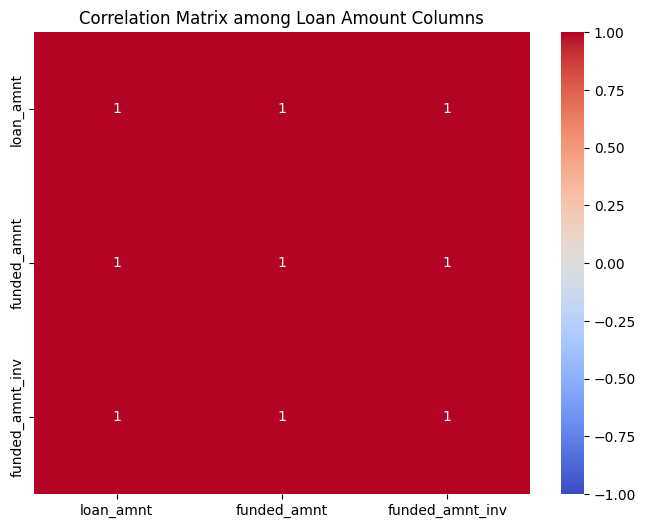

In [19]:
# 1) 분석할 컬럼 지정
cols = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv']

# 2) 상관계수 계산
corr_matrix = df[cols].corr()

# 3) Heatmap 시각화
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix among Loan Amount Columns")
plt.show()

### 7. 주택 보유 형태에 따른 변수들의 분포 확인

#### 7-1. 고유값 확인 및 각 주택 보유 형태별 loan_staus 분포 계산

In [20]:
# 고유값들 확인
df['home_ownership'].unique()
# 결측치는 제거하고 분석하기로 결정

array(['MORTGAGE', 'RENT', 'OWN', 'ANY', 'OTHER', 'NONE', nan],
      dtype=object)

Loan Status Percentage by Home Ownership:
loan_status     Charged Off  Default  Fully Paid
home_ownership                                  
MORTGAGE              16.81     0.02       83.17
RENT                  22.64     0.03       77.34
OWN                   20.07     0.03       79.91
ANY                   20.94     0.14       78.92
OTHER                 15.91     0.00       84.09
NONE                  17.86     0.00       82.14


<Figure size 1000x600 with 0 Axes>

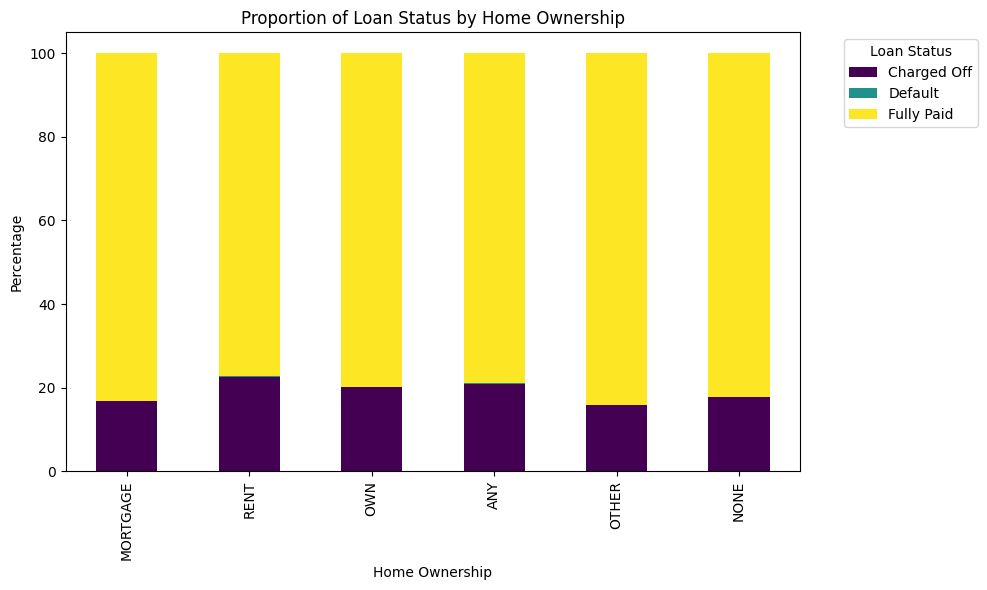

In [22]:
# loan_status가 Fully Paid, Charged Off, Default인 데이터만 남기기
valid_status = ["Fully Paid", "Charged Off", "Default"]
df_filtered = df[df['loan_status'].isin(valid_status)].copy()

# home_ownership의 NaN 값 제거
df_filtered = df_filtered.dropna(subset=['home_ownership'])

# 원하는 주택 보유 형태 순서 (필요에 따라 수정)
ownership_order = ['MORTGAGE', 'RENT', 'OWN', 'ANY', 'OTHER', 'NONE']

# 그룹별로 loan_status 개수 집계
grouped = df_filtered.groupby(['home_ownership', 'loan_status']).size().unstack(fill_value=0)

# 각 그룹별 loan_status 비율(%) 계산
grouped_pct = grouped.div(grouped.sum(axis=1), axis=0) * 100

# 만약 순서가 다르게 나타나면, 순서를 재정렬
grouped_pct = grouped_pct.reindex(ownership_order)

# 집계 결과(비율) 출력
print("Loan Status Percentage by Home Ownership:")
print(grouped_pct.round(2))

# 그래프를 그리기 전에 데이터가 숫자형임을 확인(문자열이 섞여 있다면 astype(float) 적용)
grouped_pct = grouped_pct.astype(float)

# 스택형 막대그래프로 시각화
plt.figure(figsize=(10,6))
ax = grouped_pct.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10,6))
plt.title("Proportion of Loan Status by Home Ownership")
plt.xlabel("Home Ownership")
plt.ylabel("Percentage")
plt.legend(title="Loan Status", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

##### 7-1-1. 형태별 완납 비율 차이 확인을 위한 통계적 검정

In [25]:
from scipy.stats import chi2_contingency

# 2. loan_status가 "Fully Paid", "Charged Off", "Default"인 데이터만 남기고,
#    home_ownership의 NaN은 제거
valid_status = ["Fully Paid", "Charged Off", "Default"]
df_filtered = df[df['loan_status'].isin(valid_status)].copy()
df_filtered = df_filtered.dropna(subset=['home_ownership'])

# 3. Fully Paid 여부를 이진 변수로 생성 (1: Fully Paid, 0: Charged Off or Default)
df_filtered['fully_paid'] = (df_filtered['loan_status'] == 'Fully Paid').astype(int)

# 4. 각 home_ownership별 Fully Paid와 Not Fully Paid(=0) 개수를 집계하여 컨틴전시 테이블 생성
#    (예: 각 주택 보유 형태별로 Fully Paid count와 나머지 count)
contingency = df_filtered.groupby('home_ownership')['fully_paid'].agg(['sum', 'count'])
contingency['Not Fully Paid'] = contingency['count'] - contingency['sum']
contingency = contingency[['sum', 'Not Fully Paid']]
contingency.columns = ['Fully Paid', 'Not Fully Paid']

print("Contingency Table (Counts by Home Ownership):")
print(contingency)

# 5. 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(contingency)

print("\nChi-Square Test Results:")
print(f"Chi-square statistic: {chi2:.2f}")
print(f"Degrees of Freedom: {dof}")
print(f"p-value: {p:.4f}")

# 해석 예시:
if p < 0.05:
    print("\n=> The difference in Fully Paid rates among home ownership categories is statistically significant.")
else:
    print("\n=> There is no statistically significant difference in Fully Paid rates among home ownership categories.")

Contingency Table (Counts by Home Ownership):
                Fully Paid  Not Fully Paid
home_ownership                            
ANY                    569             152
MORTGAGE            458176           92698
NONE                    23               5
OTHER                   74              14
OWN                  98278           24714
RENT                341402          100051

Chi-Square Test Results:
Chi-square statistic: 5351.77
Degrees of Freedom: 5
p-value: 0.0000

=> The difference in Fully Paid rates among home ownership categories is statistically significant.


In [26]:
# 1. 전체 데이터에서 loan_status가 유효한 값인 행만 남기고, home_ownership의 결측치 제거
valid_status = ["Fully Paid", "Charged Off", "Default"]
df_filtered = df[df['loan_status'].isin(valid_status)].copy()
df_filtered = df_filtered.dropna(subset=['home_ownership'])

# 2. Fully Paid 여부를 이진 변수로 생성 (1: Fully Paid, 0: Charged Off 또는 Default)
df_filtered['fully_paid'] = (df_filtered['loan_status'] == "Fully Paid").astype(int)

# 3. home_ownership 변수를 더미 변수로 변환 (기준 범주를 자동으로 drop_first 사용)
df_model = pd.get_dummies(df_filtered, columns=['home_ownership'], drop_first=True)

# 4. 독립 변수로 home_ownership 관련 더미 변수 선택하고 상수항 추가
X = df_model.filter(like='home_ownership_').astype(float)
X = sm.add_constant(X)

# 5. 종속 변수는 fully_paid (0 또는 1)
y = df_filtered['fully_paid']

# 6. 로지스틱 회귀 모델 적합
model = sm.Logit(y, X).fit()

# 7. 결과 출력
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.490980
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             fully_paid   No. Observations:              1116156
Model:                          Logit   Df Residuals:                  1116150
Method:                           MLE   Df Model:                            5
Date:                Sun, 02 Mar 2025   Pseudo R-squ.:                0.004848
Time:                        16:16:29   Log-Likelihood:            -5.4801e+05
converged:                       True   LL-Null:                   -5.5068e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.3200      0.091     14.457      0.000       1.141   

In [27]:
# pairwise proportion z-test를 사용하여 각 주택 보유 형태 쌍별로 Fully Paid 비율이 통계적으로 유의하게 다른지 확인하고
# Bonferroni 보정으로 다중비교
import pandas as pd
import numpy as np
from itertools import combinations
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

# (가정) df_filtered에는 이미 다음 전처리가 완료됨:
#   - loan_status in ["Fully Paid", "Charged Off", "Default"]
#   - home_ownership 결측치 제거
#   - df_filtered['fully_paid'] = (df_filtered['loan_status'] == "Fully Paid").astype(int)

# 1) 주택 보유 형태별 Fully Paid 건수와 전체 건수 구하기
categories = df_filtered['home_ownership'].unique()
data_dict = {}
for cat in categories:
    subset = df_filtered[df_filtered['home_ownership'] == cat]
    fully_paid_count = subset['fully_paid'].sum()
    total_count = len(subset)
    data_dict[cat] = (fully_paid_count, total_count)

# 2) 모든 카테고리 쌍 생성
pairs = list(combinations(categories, 2))

# 3) 쌍별로 proportion z-test 수행
pvals = []
comparisons = []
for c1, c2 in pairs:
    c1_fully, c1_total = data_dict[c1]
    c2_fully, c2_total = data_dict[c2]
    
    # proportions_ztest(count, nobs)
    count = np.array([c1_fully, c2_fully])
    nobs = np.array([c1_total, c2_total])
    
    stat, pval = proportions_ztest(count, nobs)
    comparisons.append((c1, c2))
    pvals.append(pval)

# 4) 다중 비교 보정 (Bonferroni)
reject, pvals_corrected, alpha_sidak, alpha_bonf = multipletests(pvals, alpha=0.05, method='bonferroni')

# 5) 결과 요약
results = pd.DataFrame({
    'Comparison': comparisons,
    'p-value_raw': pvals,
    'p-value_corrected': pvals_corrected,
    'reject(H0)': reject
})
results.sort_values('p-value_raw', inplace=True)
results.reset_index(drop=True, inplace=True)

print("Pairwise Comparison of Fully Paid Proportions by Home Ownership")
print(results)

Pairwise Comparison of Fully Paid Proportions by Home Ownership
           Comparison    p-value_raw  p-value_corrected  reject(H0)
0    (MORTGAGE, RENT)   0.000000e+00       0.000000e+00        True
1     (MORTGAGE, OWN)  3.529585e-164      5.294378e-163        True
2         (RENT, OWN)   3.084713e-82       4.627069e-81        True
3     (MORTGAGE, ANY)   2.279615e-03       3.419422e-02        True
4       (RENT, OTHER)   1.301648e-01       1.000000e+00       False
5        (ANY, OTHER)   2.566508e-01       1.000000e+00       False
6         (RENT, ANY)   3.105915e-01       1.000000e+00       False
7        (OWN, OTHER)   3.273687e-01       1.000000e+00       False
8          (OWN, ANY)   5.092810e-01       1.000000e+00       False
9        (RENT, NONE)   5.434961e-01       1.000000e+00       False
10        (ANY, NONE)   6.808485e-01       1.000000e+00       False
11        (OWN, NONE)   7.677212e-01       1.000000e+00       False
12      (OTHER, NONE)   8.083168e-01       1.000000e

##### 7-1-2. 검정결과 해석

카이제곱 검정 결과 주택 보유 형태에 따라 완납 비율에 차이가 있다는 점은 확인되었다. 그러나 앞선 등급별 완납 비율과 달리 모든 형태에서 차이가 두드러지는 것이 아닌 mortgage와 rent그리고 mortgage와 own, rent와 own, mortgage와 any 사이에서의 차이만 두드러졌다.

### 8. revol_util (신용 한도 대비 사용 중 잔액 비율) 관련 EDA

#### 8-1. 밸류 값들의 분포 확인

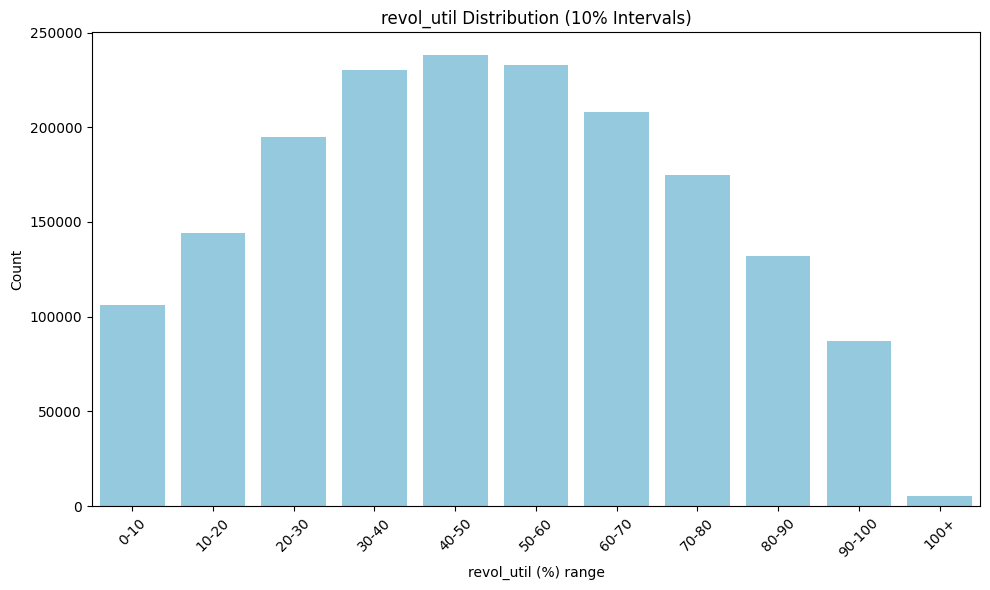

In [30]:
# revol_util 컬럼이 "21.78%"와 같이 저장되어 있다면, 먼저 % 기호를 제거하고 float로 변환
# 예: "21.78%" -> 21.78
df['revol_util'] = df['revol_util'].str.rstrip('%').astype(float)

# 결측치 제거
df_temp = df['revol_util'].dropna()

# 10% 단위로 구간(bins) 설정
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, np.inf]
labels = ["0-10", "10-20", "20-30", "30-40", "40-50", 
          "50-60", "60-70", "70-80", "80-90", "90-100", "100+"]

# 구간화 (pd.cut)
df_temp_binned = pd.cut(df_temp, bins=bins, labels=labels, include_lowest=True)

# 히스토그램(Countplot) 시각화
plt.figure(figsize=(10,6))
sns.countplot(x=df_temp_binned, order=labels, color='skyblue')
plt.xlabel("revol_util (%) range")
plt.ylabel("Count")
plt.title("revol_util Distribution (10% Intervals)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 8-2. 로그 변환 후 분포 확인

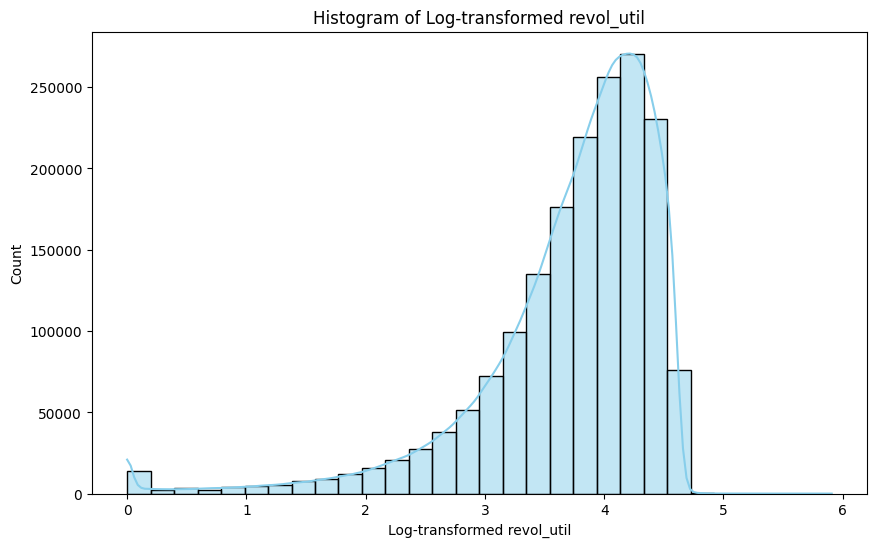

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
# 2. 로그 변환 (0 값 처리를 위해 log1p 사용)
df['log_revol_util'] = np.log1p(df['revol_util'])

# 3. 로그 변환된 값의 히스토그램 시각화
plt.figure(figsize=(10,6))
sns.histplot(df['log_revol_util'].dropna(), bins=30, kde=True, color='skyblue')
plt.xlabel("Log-transformed revol_util")
plt.ylabel("Count")
plt.title("Histogram of Log-transformed revol_util")
plt.show()

#### 8-4. 그룹별 revol_util 분포 비교

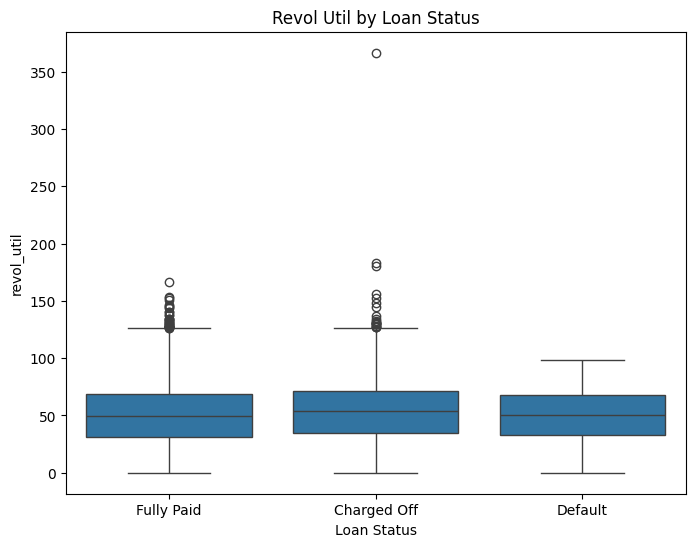

In [9]:
valid_status = ["Fully Paid", "Charged Off", "Default"]
df_filtered = df[df['loan_status'].isin(valid_status)].copy()

plt.figure(figsize=(8,6))
sns.boxplot(x='loan_status', y='revol_util', data=df_filtered)
plt.title("Revol Util by Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("revol_util")
plt.show()

##### 8-4-1. 구간화 후 부도율 확인

In [19]:
bins = [0, 30, 60, 90, 200]  # 100% 초과값도 고려
labels = ["0-30", "30-60", "60-90", "90+"]
df_filtered['revol_util_bin'] = pd.cut(df_filtered['revol_util'], bins=bins, labels=labels, include_lowest=True)

grouped = df_filtered.groupby('revol_util_bin')['loan_status'].value_counts(normalize=True)
print(grouped)

revol_util_bin  loan_status
0-30            Fully Paid     0.838139
                Charged Off    0.161629
                Default        0.000232
30-60           Fully Paid     0.802389
                Charged Off    0.197369
                Default        0.000243
60-90           Fully Paid     0.788309
                Charged Off    0.211436
                Default        0.000255
90+             Fully Paid     0.780343
                Charged Off    0.219484
                Default        0.000174
Name: proportion, dtype: float64


/var/folders/h6/g8v1gdc16gxd6ztn281rfcn40000gn/T/ipykernel_57484/2835890798.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_filtered.groupby('revol_util_bin')['loan_status'].value_counts(normalize=True)


##### 8-4-2. 구간별 부도율 변화 통계적 검증 및 추세 확인 (로지스틱 회귀)

In [21]:
import statsmodels.api as sm

# 1) 필요한 컬럼에서 결측치 제거
df_filtered = df_filtered.dropna(subset=['revol_util_bin', 'not_fully_paid'])

# 2) get_dummies로 revol_util_bin을 더미 변수화 (drop_first=True => "0-30"이 기준)
df_model = pd.get_dummies(df_filtered, columns=['revol_util_bin'], drop_first=True)

# 3) 독립 변수(X): revol_util_bin_* 컬럼들
X = df_model.filter(like='revol_util_bin_')

# 4) 종속 변수(y): not_fully_paid
y = df_model['not_fully_paid']

# 5) 데이터 타입을 숫자형으로 강제 변환 (문자열 등이 섞여 있을 수 있으므로)
X = X.astype(float)
y = y.astype(float)

# 6) 상수항 추가
X = sm.add_constant(X)

# 7) 로지스틱 회귀 모델 적합
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.492128
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         not_fully_paid   No. Observations:              1115315
Model:                          Logit   Df Residuals:                  1115311
Method:                           MLE   Df Model:                            3
Date:                Sun, 02 Mar 2025   Pseudo R-squ.:                0.002504
Time:                        16:59:47   Log-Likelihood:            -5.4888e+05
converged:                       True   LL-Null:                   -5.5026e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.6444      0.005   -307.864      0.000      -1.655      -1.634

##### 8-4-3. 검정 결과 해석 

로지스틱 회귀 결과 신용 한도 대비 사용 중 잔액 비율이 0-30% 대에서 높아질 수록 부도확률이 높아지는 경향이 있고 통계적으로 이 결과가 유의함을 도출. 따라서 revol_util이 부도예측모형을 세우는 데 유의한 피쳐임을 확인하였다.

### 9. sec와 primary

In [23]:
# sec_app_fico_range_low가 결측치가 아닌 행 필터링
filtered_df = df[df['sec_app_fico_range_low'].notna()]

# application_type의 고유값과 개수 계산
application_type_counts = filtered_df['application_type'].value_counts()

print(application_type_counts)

application_type
Joint App    118705
Name: count, dtype: int64


                Column  Total Data  Missing Count  Missing Percentage
0          open_acc_6m     1116156         507841           45.499106
1          open_act_il     1116156         507841           45.499106
2          open_il_12m     1116156         507841           45.499106
3          open_il_24m     1116156         507841           45.499106
4   mths_since_rcnt_il     1116156         525297           47.063045
5         total_bal_il     1116156         507841           45.499106
6              il_util     1116156         593310           53.156548
7          open_rv_12m     1116156         507841           45.499106
8          open_rv_24m     1116156         507841           45.499106
9           max_bal_bc     1116156         507841           45.499106
10            all_util     1116156         507923           45.506453


/var/folders/h6/g8v1gdc16gxd6ztn281rfcn40000gn/T/ipykernel_62723/3216267188.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(missing_df["Column"], rotation=45, ha="right")


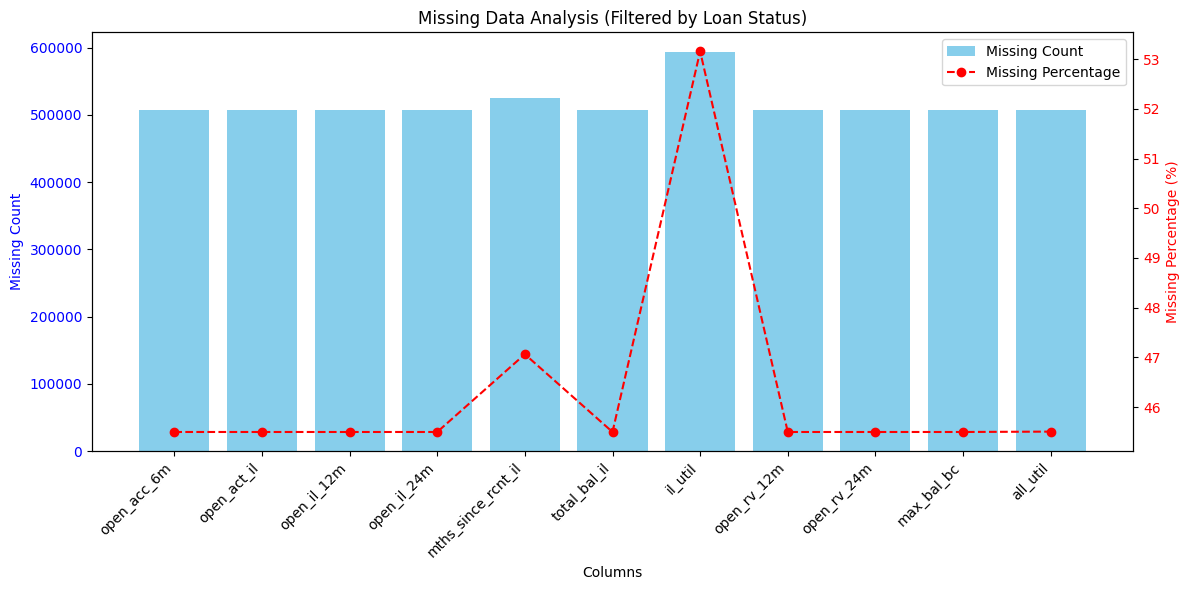

In [30]:
# 1. loan_status가 "Fully Paid", "Charged Off", "Default"인 행만 선택
statuses_to_keep = ['Fully Paid', 'Charged Off', 'Default']
df_filtered = df[df['loan_status'].isin(statuses_to_keep)]

# 2. 분석 대상 칼럼 리스트
cols = [
    "open_acc_6m", "open_act_il", "open_il_12m", "open_il_24m", "mths_since_rcnt_il",
    "total_bal_il", "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc", "all_util"
]

# 3. 전체 데이터 개수 (필터링된 데이터 기준)
total_count = len(df_filtered)

# 4. 각 칼럼별 결측치 통계 계산
missing_stats = {
    "Column": [],
    "Total Data": [],
    "Missing Count": [],
    "Missing Percentage": []
}

for col in cols:
    missing_count = df_filtered[col].isnull().sum()
    missing_percentage = (missing_count / total_count) * 100
    missing_stats["Column"].append(col)
    missing_stats["Total Data"].append(total_count)
    missing_stats["Missing Count"].append(missing_count)
    missing_stats["Missing Percentage"].append(missing_percentage)

# 5. 결과를 DataFrame으로 변환하여 출력
missing_df = pd.DataFrame(missing_stats)
print(missing_df)

# 6. 시각화: 결측치 개수와 결측치 비율을 동시에 표시
fig, ax1 = plt.subplots(figsize=(12, 6))

# 왼쪽 축: 결측치 개수 (Bar Plot)
ax1.bar(missing_df["Column"], missing_df["Missing Count"], color='skyblue', label="Missing Count")
ax1.set_xlabel("Columns")
ax1.set_ylabel("Missing Count", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.set_xticklabels(missing_df["Column"], rotation=45, ha="right")

# 오른쪽 축: 결측치 비율 (Line Plot)
ax2 = ax1.twinx()
ax2.plot(missing_df["Column"], missing_df["Missing Percentage"], color='red', marker='o', linestyle='--', label="Missing Percentage")
ax2.set_ylabel("Missing Percentage (%)", color="red")
ax2.tick_params(axis='y', labelcolor="red")

# 범례 결합하여 설정
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.title("Missing Data Analysis (Filtered by Loan Status)")
plt.tight_layout()
plt.show()